In [2]:
!pip install catboost -q
!pip install optuna -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 6.3 MB/s eta 0:00:00


In [92]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import log_loss, roc_auc_score, classification_report, f1_score, mean_squared_error
from sklearn.model_selection import train_test_split

from catboost import CatBoostClassifier, Pool, CatBoostRegressor

import optuna
from optuna.samplers import TPESampler
from catboost.utils import eval_metric

In [74]:
df_discounts = pd.read_csv('/content/discounts_raw.csv')
df_sales = pd.read_csv('/content/sales_raw.csv')

In [75]:
# добавление новых строк для прогноза на январь 2024
df_january_sales =  pd.DataFrame({'date':pd.date_range(start='2024-01-01', end='2024-01-31')})
df_january_sales['date'] = df_january_sales['date'].map(lambda t: t.strftime('%Y-%m-%d'))

# список уникальных товаров, которые были проданы в декабре 2023
unique_item_2023 = df_sales['item_id'][(df_sales['date']>='2023-12-01') & (df_sales['date'] <='2023-12-31')].unique()
df_unique_item = pd.DataFrame({'item_id': unique_item_2023})

# создание строк продажи товара для каждого дня января 2024
df_january_sales = pd.merge(df_january_sales.assign(key=1), df_unique_item.assign(key=1), on='key').drop('key', axis=1)
df_january_sales['qnty'] = 0

# конкатенция новых строк для прогноза на январь 2024
df_sales = pd.concat([df_sales, df_january_sales], axis=0)

# Подготовка данных и генерация новых признаков


In [76]:
# приведение столбца даты к формату datetime
df_discounts['date_start'] = pd.to_datetime(df_discounts['date_start'], format='%Y-%m-%d')
df_discounts['date_end'] = pd.to_datetime(df_discounts['date_end'], format='%Y-%m-%d')
df_sales['date'] = pd.to_datetime(df_sales['date'], format='%Y-%m-%d')

In [77]:
# Добавляем новые признаки в датасет

# День недели
df_sales['day_of_week'] = df_sales['date'].dt.dayofweek

# Выходной день
df_sales['is_weekend'] = df_sales['day_of_week'].isin([5, 6]).astype(int)

# Месяц и год
df_sales['month'] = df_sales['date'].dt.month
df_sales['year'] = df_sales['date'].dt.year

# Время года
seasons = {(1, 12, 2): 1, # зима
           (3, 4, 5): 2,  # весна
           (6, 7, 8): 3,  # лето
           (9, 10, 11): 4}# осень

def season(ser):
    for k in seasons.keys():
        if ser in k:
            return seasons[k]

df_sales['season'] = df_sales['date'].dt.month.apply(lambda x: season(x))

In [78]:
# Дата прошлого года продажи
df_sales['prev_year_date'] = df_sales['date'] - pd.DateOffset(years=1)

# Информация о продажах в прошлом году
df_sales_prev_year = df_sales[['date', 'item_id', 'qnty']].rename(columns={'date': 'prev_year_date', 'qnty': 'prev_year_qnty'})
df_sales = pd.merge(df_sales, df_sales_prev_year, on=['item_id', 'prev_year_date'], how='left')

# Если нет информации о продажах в прошлом году, то 0
df_sales['prev_year_qnty'].fillna(0, inplace=True)

# prev_year_date не нужна
df_sales.drop(columns=['prev_year_date'], inplace=True)

In [79]:
# размер скидки и на какой процент она сбрасывает цену товара
df_discounts['discount'] = df_discounts['sale_price_before_promo'] - df_discounts['sale_price_time_promo']
df_discounts['discount_rate'] = df_discounts['discount'] / df_discounts['sale_price_before_promo']

# сколько длилась акция
df_discounts['days_promo'] = df_discounts['date_end'] - df_discounts['date_start']
df_discounts['days_promo'] = df_discounts['days_promo'].dt.days

# новый признак признак по квантилю дней акции
df_discounts['days_promo_category'] = pd.qcut(df_discounts['days_promo'], q=2, labels=['short', 'long'])

In [82]:
df_discounts.isna().sum()

item_id                     0
promo_typeCode             40
sale_price_before_promo     0
sale_price_time_promo       0
date_start                  0
date_end                    0
discount                    0
discount_rate               0
days_promo                  0
days_promo_category         0
dtype: int64

в столбце promo_typeCode есть пропущенные значение, я буду их восстанавливать с помощью catboost

## восстановление пропущенных значений

In [83]:
# формирование датасета
df_discounts_new = df_discounts[['promo_typeCode',
                                'item_id',
                                'sale_price_before_promo',
                                'sale_price_time_promo',
                                'discount',
                                'discount_rate',
                                'days_promo',
                                'days_promo_category'
                               ]]

# нет пропусков в promo_typeCode, будет использоваться в тренировке
df_discounts_pred = df_discounts_new[df_discounts_new['promo_typeCode' ].isna()]
# есть пропуски в promo_typeCode
df_discounts_new= df_discounts_new[~df_discounts_new['promo_typeCode' ].isna()]

In [84]:
# формирование тренировочной и тестовой выборки
y = df_discounts_new['promo_typeCode']
x = df_discounts_new.drop('promo_typeCode', axis=1)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

categorical_features_names = ['item_id', 'days_promo_category']

train_dataset = Pool(data=X_train,
                     label=y_train,
                     cat_features=categorical_features_names)

eval_dataset = Pool(data=X_test,
                    label=y_test,
                    cat_features=categorical_features_names)

In [93]:
model = CatBoostClassifier(iterations=1000, learning_rate=0.03, eval_metric='Accuracy')
# Fit model
model.fit(train_dataset, eval_set=eval_dataset, verbose=100)


0:	learn: 0.5386029	test: 0.5599022	best: 0.5599022 (0)	total: 33.2ms	remaining: 33.2s
100:	learn: 0.7500000	test: 0.7897311	best: 0.7921760 (57)	total: 3.64s	remaining: 32.4s
200:	learn: 0.7714461	test: 0.8068460	best: 0.8068460 (191)	total: 6.07s	remaining: 24.1s
300:	learn: 0.7922794	test: 0.8141809	best: 0.8141809 (230)	total: 8.52s	remaining: 19.8s
400:	learn: 0.8204657	test: 0.8166259	best: 0.8264059 (331)	total: 11s	remaining: 16.5s
500:	learn: 0.8412990	test: 0.8288509	best: 0.8288509 (478)	total: 13.5s	remaining: 13.5s
600:	learn: 0.8560049	test: 0.8435208	best: 0.8459658 (580)	total: 17.7s	remaining: 11.7s
700:	learn: 0.8743873	test: 0.8508557	best: 0.8508557 (693)	total: 21.3s	remaining: 9.07s
800:	learn: 0.8878676	test: 0.8655257	best: 0.8655257 (750)	total: 27s	remaining: 6.7s
900:	learn: 0.8952206	test: 0.8630807	best: 0.8655257 (750)	total: 31.9s	remaining: 3.5s
999:	learn: 0.8988971	test: 0.8581907	best: 0.8655257 (750)	total: 34.4s	remaining: 0us

bestTest = 0.86552567

In [94]:
# метрики качества прогноза для задачи классификации типа промо
class_predictions = model.predict(X_test)
class_report = classification_report(y_test, class_predictions)
print(f'Classification Report:\n {class_report}')

Classification Report:
               precision    recall  f1-score   support

         1.0       1.00      1.00      1.00         1
         2.0       1.00      1.00      1.00         2
         5.0       0.87      0.90      0.88       200
         6.0       0.88      0.88      0.88       156
         7.0       1.00      1.00      1.00         1
         8.0       0.83      0.71      0.77        14
        10.0       0.77      0.77      0.77        26
        16.0       0.00      0.00      0.00         2
        23.0       1.00      1.00      1.00         1
        44.0       0.50      0.17      0.25         6

    accuracy                           0.87       409
   macro avg       0.79      0.74      0.76       409
weighted avg       0.86      0.87      0.86       409



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# точность прогноза 0.87, приемлемо для восстановления пропущенных значений

df_discounts_pred = df_discounts_pred.drop('promo_typeCode', axis=1)
pred_promo_typeCode =  model.predict(df_discounts_pred)
df_discounts_pred['promo_typeCode'] = pred_promo_typeCode

df_discounts['promo_typeCode'][df_discounts['promo_typeCode' ].isna()] = df_discounts_pred['promo_typeCode']

## передача фичей из df_discounts в df_sales по распродажами

In [ ]:
def transfer_columns(row, sale_date):
    # фильтрация акции по полученному ид товара
    df_mini = df_discounts[df_discounts['item_id'] == row['item_id']]

    # проверка даты проводимой акции для товара
    for _, mini_row in df_mini.iterrows():
        if mini_row['date_start'] <= sale_date <= mini_row['date_end']:
            res = {
                'promo_typeCode': mini_row['promo_typeCode'],
                'sale_price_before_promo': mini_row['sale_price_before_promo'],
                'discount': mini_row['discount'],
                'discount_rate': mini_row['discount_rate'],
                'days_promo_category': mini_row['days_promo_category'],
                'promo_active': 1,
                }
            return res
        elif mini_row['date_start'] > sale_date:
            res = []
        elif mini_row['date_end'] < sale_date:
            res = []

    res = {
        'promo_typeCode': np.nan,
        'sale_price_before_promo': np.nan,
        'discount': np.nan,
        'discount_rate': np.nan,
        'days_promo_category': np.nan,
        'promo_active': np.nan,
        }
    return res

# получение новых признаков из датасета акций
df_sales['dict'] = df_sales.apply(lambda row: transfer_columns(row, row['date']), axis=1)


In [ ]:
# раскрытие словаря из столбца dict
df_normalized = pd.json_normalize(df_sales['dict'])
df_sales = pd.concat([df_sales.drop(columns=['dict']), df_normalized], axis=1)

# заполнение строк, в которых не было информации о проводимой акции
df_sales['days_promo_category'].fillna(value='no', inplace =True)
df_sales['days_promo_category'] = df_sales['days_promo_category'].apply(lambda x: 'no' if x == 0 else x)
df_sales['promo_typeCode'].fillna(value=0, inplace =True)
df_sales['promo_typeCode'] = df_sales['promo_typeCode'].astype(int)
df_sales['discount'].fillna(value=0, inplace =True)
df_sales['discount_rate'].fillna(value=0, inplace =True)
df_sales['promo_active'].fillna(value=0, inplace =True)
df_sales = df_sales.drop('sale_price_before_promo', axis=1, inplace=True)


# создание признака - категория продаж по квантилю проданных товаров
df_second = pd.DataFrame()
df_second['sold_qnty'] = df_sales.groupby('item_id')['qnty'].sum()
df_second['item_id_category'] = pd.qcut(df_second['sold_qnty'], q=3, labels=['rare',
                                                                              'regular',
                                                                              'popular'])
df_second['item_id'] = df_second.index
df_second.reset_index(drop=True, inplace=True)
df_second.drop(columns=['sold_qnty'], inplace=True)
# добавление признака в датасет
df_sales = pd.merge(df_sales, df_second, on=['item_id'], how='inner')

# Обучение модели

In [56]:
# т.к. задача time series, то нужно отсортировать данных по дате
df_sales = df_sales.sort_values(by='date')

In [63]:
# датасет для предсказания января 2024
x_pred = df_sales[(df_sales['date']>='2024-01-01')]
x_pred = x_pred.drop(['qnty'], axis=1)

df_res = x_pred[['date', 'item_id']]
df_res = df_res.reset_index(drop=True)

# датасет до января 2024
x = df_sales[(df_sales['date'] < '2024-01-01')]
x = x.drop(['date'], axis=1)
y = x['qnty']
x = x.drop(['qnty'], axis=1)

# формирование тренировочной и тестовой выборки
X_train, X_test = train_test_split(x, test_size=0.2, shuffle=False)
y_train, y_test = train_test_split(y, test_size=0.2, shuffle=False)

categorical_features_names = ['item_id', 'day_of_week', 'month', 'year','season',
                              'promo_typeCode','days_promo_category', 'item_id_category']
train_pool = Pool(X_train,
                  label=y_train,
                  cat_features=categorical_features_names)
test_pool = Pool(X_test,
                 label=y_test,
                 cat_features=categorical_features_names)

## Поиск гиперпараметров и обучение модели


In [72]:
def objective(trial):
    params = {
        "iterations": 500,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
    }

    model = CatBoostRegressor(**params, silent=True)
    model.fit(train_pool, eval_set=test_pool, verbose=100, use_best_model=True)
    predictions = model.predict(X_test)
    rmse = mean_squared_error(y_test, predictions, squared=False) # if squared=True return MSE
    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

[I 2024-07-28 16:46:42,755] A new study created in memory with name: no-name-fe7700ce-1359-470e-bbec-823ad2aef833


0:	learn: 26.6159447	test: 31.1122114	best: 31.1122114 (0)	total: 503ms	remaining: 4m 11s
100:	learn: 18.3022787	test: 20.7571703	best: 20.7571703 (100)	total: 16.4s	remaining: 1m 4s
200:	learn: 14.2929099	test: 16.0592574	best: 16.0592574 (200)	total: 32.8s	remaining: 48.8s
300:	learn: 12.4053727	test: 14.0495603	best: 14.0495603 (300)	total: 48.2s	remaining: 31.9s
400:	learn: 11.5526869	test: 14.0986866	best: 13.9119752 (347)	total: 1m 9s	remaining: 17.1s
499:	learn: 11.1120677	test: 14.4075721	best: 13.9119752 (347)	total: 1m 25s	remaining: 0us

bestTest = 13.91197516
bestIteration = 347

Shrink model to first 348 iterations.


[I 2024-07-28 16:48:09,038] Trial 0 finished with value: 13.911975160359557 and parameters: {'learning_rate': 0.005688533942083845, 'depth': 8, 'subsample': 0.3292049248647309, 'colsample_bylevel': 0.6045299567925547, 'min_data_in_leaf': 81}. Best is trial 0 with value: 13.911975160359557.


0:	learn: 26.6542093	test: 31.1392743	best: 31.1392743 (0)	total: 25.8ms	remaining: 12.9s
100:	learn: 23.0051777	test: 25.9617145	best: 25.9617145 (100)	total: 1.83s	remaining: 7.22s
200:	learn: 20.2107013	test: 22.0150910	best: 22.0150910 (200)	total: 3.6s	remaining: 5.36s
300:	learn: 18.9820793	test: 20.4103830	best: 20.4103830 (300)	total: 5.36s	remaining: 3.54s
400:	learn: 18.1452236	test: 19.4985692	best: 19.4985692 (400)	total: 7.35s	remaining: 1.81s


[I 2024-07-28 16:48:20,109] Trial 1 finished with value: 18.99186781432597 and parameters: {'learning_rate': 0.008667956337512064, 'depth': 2, 'subsample': 0.6671508173435705, 'colsample_bylevel': 0.18372747045896864, 'min_data_in_leaf': 3}. Best is trial 0 with value: 13.911975160359557.


499:	learn: 17.6233084	test: 18.9926130	best: 18.9918678 (498)	total: 10.7s	remaining: 0us

bestTest = 18.99186781
bestIteration = 498

Shrink model to first 499 iterations.
0:	learn: 26.6902071	test: 31.2120967	best: 31.2120967 (0)	total: 82.7ms	remaining: 41.2s
100:	learn: 23.0497593	test: 26.3680137	best: 26.3680137 (100)	total: 7.05s	remaining: 27.9s
200:	learn: 20.1461270	test: 22.6446311	best: 22.6446311 (200)	total: 15.7s	remaining: 23.3s
300:	learn: 17.9491104	test: 19.9369502	best: 19.9369502 (300)	total: 22.4s	remaining: 14.8s
400:	learn: 16.3730470	test: 18.0087421	best: 18.0087421 (400)	total: 31.3s	remaining: 7.72s
499:	learn: 15.2693649	test: 16.6781196	best: 16.6781196 (499)	total: 39.7s	remaining: 0us

bestTest = 16.67811961
bestIteration = 499



[I 2024-07-28 16:49:00,357] Trial 2 finished with value: 16.678119609361243 and parameters: {'learning_rate': 0.0024120533874838384, 'depth': 4, 'subsample': 0.9021005105850901, 'colsample_bylevel': 0.5251447402648634, 'min_data_in_leaf': 65}. Best is trial 0 with value: 13.911975160359557.


0:	learn: 26.6147046	test: 31.0789503	best: 31.0789503 (0)	total: 52.3ms	remaining: 26.1s
100:	learn: 18.9079444	test: 19.9625329	best: 19.9625329 (100)	total: 3.06s	remaining: 12.1s
200:	learn: 16.4260111	test: 17.0094782	best: 17.0094782 (200)	total: 5.71s	remaining: 8.5s
300:	learn: 15.6206655	test: 16.2542466	best: 16.2529803 (293)	total: 8.11s	remaining: 5.36s
400:	learn: 15.1542616	test: 15.9717392	best: 15.9673556 (395)	total: 11.8s	remaining: 2.91s


[I 2024-07-28 16:49:15,889] Trial 3 finished with value: 15.474494410367875 and parameters: {'learning_rate': 0.012623849543239802, 'depth': 2, 'subsample': 0.7381033560109088, 'colsample_bylevel': 0.5729900718278039, 'min_data_in_leaf': 28}. Best is trial 0 with value: 13.911975160359557.


499:	learn: 14.6569265	test: 15.4760183	best: 15.4744944 (497)	total: 15.1s	remaining: 0us

bestTest = 15.47449441
bestIteration = 497

Shrink model to first 498 iterations.
0:	learn: 26.7144451	test: 31.2401930	best: 31.2401930 (0)	total: 13.9ms	remaining: 6.96s
100:	learn: 25.2640784	test: 29.2710647	best: 29.2710647 (99)	total: 2.88s	remaining: 11.4s
200:	learn: 23.7600018	test: 27.3656157	best: 27.3656157 (200)	total: 5.76s	remaining: 8.58s
300:	learn: 22.3681540	test: 25.5610690	best: 25.5610688 (299)	total: 9.02s	remaining: 5.96s
400:	learn: 21.2838758	test: 24.1613952	best: 24.1613952 (400)	total: 13.3s	remaining: 3.29s
499:	learn: 20.4053112	test: 23.0355338	best: 23.0355272 (498)	total: 16.2s	remaining: 0us

bestTest = 23.03552723
bestIteration = 498

Shrink model to first 499 iterations.


[I 2024-07-28 16:49:32,716] Trial 4 finished with value: 23.035527232973948 and parameters: {'learning_rate': 0.0017313491411716623, 'depth': 5, 'subsample': 0.16171548796592217, 'colsample_bylevel': 0.11663564608656482, 'min_data_in_leaf': 79}. Best is trial 0 with value: 13.911975160359557.


0:	learn: 26.5627295	test: 31.0442544	best: 31.0442544 (0)	total: 258ms	remaining: 2m 8s
100:	learn: 15.7104625	test: 18.2243373	best: 18.2243373 (100)	total: 26.9s	remaining: 1m 46s
200:	learn: 12.1190441	test: 14.6470753	best: 14.5964032 (197)	total: 54.2s	remaining: 1m 20s
300:	learn: 10.9651535	test: 14.5700289	best: 14.2606317 (256)	total: 1m 21s	remaining: 53.9s
400:	learn: 10.5354614	test: 15.2327873	best: 14.2606317 (256)	total: 1m 49s	remaining: 27.1s
499:	learn: 10.3113761	test: 15.6583698	best: 14.2606317 (256)	total: 2m 17s	remaining: 0us

bestTest = 14.26063171
bestIteration = 256

Shrink model to first 257 iterations.


[I 2024-07-28 16:51:50,439] Trial 5 finished with value: 14.260631707060522 and parameters: {'learning_rate': 0.008295921948145215, 'depth': 10, 'subsample': 0.8846885299646576, 'colsample_bylevel': 0.4016387191935055, 'min_data_in_leaf': 53}. Best is trial 0 with value: 13.911975160359557.


0:	learn: 25.8817943	test: 30.1700135	best: 30.1700135 (0)	total: 126ms	remaining: 1m 2s
100:	learn: 11.1941152	test: 14.7059495	best: 13.3705722 (76)	total: 10.9s	remaining: 42.9s
200:	learn: 10.7638635	test: 17.1933799	best: 13.3705722 (76)	total: 21.6s	remaining: 32.1s
300:	learn: 10.5051409	test: 17.0575627	best: 13.3705722 (76)	total: 31.2s	remaining: 20.6s
400:	learn: 10.3001294	test: 16.4966926	best: 13.3705722 (76)	total: 43.2s	remaining: 10.7s


[I 2024-07-28 16:52:46,660] Trial 6 finished with value: 13.370572210158109 and parameters: {'learning_rate': 0.04277137834362025, 'depth': 6, 'subsample': 0.054046609252248204, 'colsample_bylevel': 0.8836949414527551, 'min_data_in_leaf': 83}. Best is trial 6 with value: 13.370572210158109.


499:	learn: 10.1995622	test: 16.7096846	best: 13.3705722 (76)	total: 55.8s	remaining: 0us

bestTest = 13.37057221
bestIteration = 76

Shrink model to first 77 iterations.
0:	learn: 26.5014781	test: 30.8849026	best: 30.8849026 (0)	total: 63.2ms	remaining: 31.5s
100:	learn: 12.1037252	test: 13.5365832	best: 13.5365832 (100)	total: 10.6s	remaining: 42s
200:	learn: 10.8576122	test: 14.2573703	best: 12.9874150 (141)	total: 21.2s	remaining: 31.5s
300:	learn: 10.5437562	test: 15.7153228	best: 12.9874150 (141)	total: 29.9s	remaining: 19.7s
400:	learn: 10.3469307	test: 16.8274036	best: 12.9874150 (141)	total: 40s	remaining: 9.87s
499:	learn: 10.1884522	test: 17.0373767	best: 12.9874150 (141)	total: 49.7s	remaining: 0us

bestTest = 12.98741499
bestIteration = 141

Shrink model to first 142 iterations.


[I 2024-07-28 16:53:36,906] Trial 7 finished with value: 12.987414985293807 and parameters: {'learning_rate': 0.020008570143683187, 'depth': 8, 'subsample': 0.23763284260215956, 'colsample_bylevel': 0.22673996734639706, 'min_data_in_leaf': 30}. Best is trial 7 with value: 12.987414985293807.


0:	learn: 25.8863630	test: 30.1431740	best: 30.1431740 (0)	total: 264ms	remaining: 2m 11s
100:	learn: 10.5938849	test: 15.7421899	best: 13.9908204 (61)	total: 28.7s	remaining: 1m 53s
200:	learn: 10.0926471	test: 17.2048095	best: 13.9908204 (61)	total: 56.9s	remaining: 1m 24s
300:	learn: 9.7744341	test: 17.7320718	best: 13.9908204 (61)	total: 1m 24s	remaining: 55.7s
400:	learn: 9.5188698	test: 18.0178925	best: 13.9908204 (61)	total: 1m 54s	remaining: 28.2s
499:	learn: 9.3299635	test: 18.1292741	best: 13.9908204 (61)	total: 2m 25s	remaining: 0us

bestTest = 13.99082043
bestIteration = 61

Shrink model to first 62 iterations.


[I 2024-07-28 16:56:03,389] Trial 8 finished with value: 13.99082043457588 and parameters: {'learning_rate': 0.04374903942192081, 'depth': 9, 'subsample': 0.6891609802050966, 'colsample_bylevel': 0.9007432419313949, 'min_data_in_leaf': 30}. Best is trial 7 with value: 12.987414985293807.


0:	learn: 26.6815836	test: 31.2191783	best: 31.2191783 (0)	total: 39.7ms	remaining: 19.8s
100:	learn: 21.7650833	test: 24.2629330	best: 24.2621332 (98)	total: 1.37s	remaining: 5.42s
200:	learn: 18.9118173	test: 20.3081204	best: 20.3075604 (196)	total: 2.78s	remaining: 4.14s
300:	learn: 18.1202162	test: 19.5796040	best: 19.5638131 (258)	total: 4.2s	remaining: 2.77s
400:	learn: 17.8365477	test: 19.4778747	best: 19.4778747 (400)	total: 5.54s	remaining: 1.37s


[I 2024-07-28 16:56:10,654] Trial 9 finished with value: 18.976558090516995 and parameters: {'learning_rate': 0.039686270628136365, 'depth': 2, 'subsample': 0.48803154857904835, 'colsample_bylevel': 0.09674657766174038, 'min_data_in_leaf': 2}. Best is trial 7 with value: 12.987414985293807.


499:	learn: 17.2185072	test: 18.9765592	best: 18.9765581 (498)	total: 6.82s	remaining: 0us

bestTest = 18.97655809
bestIteration = 498

Shrink model to first 499 iterations.
0:	learn: 26.5111682	test: 30.8964422	best: 30.8964422 (0)	total: 66.2ms	remaining: 33s
100:	learn: 12.1729173	test: 12.8006120	best: 12.8006120 (100)	total: 10.4s	remaining: 41.1s
200:	learn: 10.9258443	test: 13.7635764	best: 12.3748398 (119)	total: 20.9s	remaining: 31.2s
300:	learn: 10.5749860	test: 15.6274452	best: 12.3748398 (119)	total: 29.9s	remaining: 19.7s
400:	learn: 10.3985216	test: 16.4368848	best: 12.3748398 (119)	total: 41.1s	remaining: 10.2s
499:	learn: 10.2540855	test: 16.5922189	best: 12.3748398 (119)	total: 52s	remaining: 0us

bestTest = 12.3748398
bestIteration = 119

Shrink model to first 120 iterations.


[I 2024-07-28 16:57:03,153] Trial 10 finished with value: 12.374839798032161 and parameters: {'learning_rate': 0.019129947506427516, 'depth': 7, 'subsample': 0.3549984305798042, 'colsample_bylevel': 0.3301740643802134, 'min_data_in_leaf': 27}. Best is trial 10 with value: 12.374839798032161.


0:	learn: 26.4929532	test: 30.8656318	best: 30.8656318 (0)	total: 65.8ms	remaining: 32.8s
100:	learn: 12.2367105	test: 14.0588314	best: 14.0554700 (99)	total: 10.7s	remaining: 42.3s
200:	learn: 11.0192356	test: 15.8451981	best: 13.7996835 (113)	total: 21.4s	remaining: 31.8s
300:	learn: 10.6641780	test: 17.9454626	best: 13.7996835 (113)	total: 31.1s	remaining: 20.6s
400:	learn: 10.4536638	test: 18.4245543	best: 13.7996835 (113)	total: 42.5s	remaining: 10.5s
499:	learn: 10.3082108	test: 19.0620705	best: 13.7996835 (113)	total: 53.9s	remaining: 0us

bestTest = 13.79968354
bestIteration = 113

Shrink model to first 114 iterations.


[I 2024-07-28 16:57:57,471] Trial 11 finished with value: 13.799683535022249 and parameters: {'learning_rate': 0.020736553101575468, 'depth': 7, 'subsample': 0.39222847117770815, 'colsample_bylevel': 0.3216254843442927, 'min_data_in_leaf': 27}. Best is trial 10 with value: 12.374839798032161.


0:	learn: 26.3430734	test: 30.7463109	best: 30.7463109 (0)	total: 117ms	remaining: 58.4s
100:	learn: 11.9709352	test: 13.6552781	best: 13.6552781 (100)	total: 11.6s	remaining: 45.8s
200:	learn: 10.7447891	test: 15.1738090	best: 13.5867309 (134)	total: 23s	remaining: 34.2s
300:	learn: 10.4259139	test: 16.8041945	best: 13.5867309 (134)	total: 34.5s	remaining: 22.8s
400:	learn: 10.2466939	test: 17.1895743	best: 13.5867309 (134)	total: 45.7s	remaining: 11.3s
499:	learn: 10.0771464	test: 17.1947007	best: 13.5867309 (134)	total: 57.7s	remaining: 0us

bestTest = 13.5867309
bestIteration = 134

Shrink model to first 135 iterations.


[I 2024-07-28 16:58:55,688] Trial 12 finished with value: 13.586730899634588 and parameters: {'learning_rate': 0.019999152786548118, 'depth': 8, 'subsample': 0.24838723591055356, 'colsample_bylevel': 0.29811210277660694, 'min_data_in_leaf': 40}. Best is trial 10 with value: 12.374839798032161.


0:	learn: 24.8479211	test: 28.8076796	best: 28.8076796 (0)	total: 132ms	remaining: 1m 5s
100:	learn: 10.7002943	test: 31.7777150	best: 15.4679561 (26)	total: 10.5s	remaining: 41.6s
200:	learn: 10.2110878	test: 42.4237596	best: 15.4679561 (26)	total: 21s	remaining: 31.2s
300:	learn: 9.9577548	test: 41.4438397	best: 15.4679561 (26)	total: 32.9s	remaining: 21.7s
400:	learn: 9.7726262	test: 41.5124141	best: 15.4679561 (26)	total: 44.3s	remaining: 10.9s


[I 2024-07-28 16:59:50,912] Trial 13 finished with value: 15.467956137981032 and parameters: {'learning_rate': 0.09692735584209902, 'depth': 6, 'subsample': 0.4969735889410323, 'colsample_bylevel': 0.39982170392572136, 'min_data_in_leaf': 14}. Best is trial 10 with value: 12.374839798032161.


499:	learn: 9.6431960	test: 43.2265904	best: 15.4679561 (26)	total: 54.9s	remaining: 0us

bestTest = 15.46795614
bestIteration = 26

Shrink model to first 27 iterations.
0:	learn: 26.6651865	test: 31.1817874	best: 31.1817874 (0)	total: 152ms	remaining: 1m 15s
100:	learn: 21.3815951	test: 24.9454793	best: 24.9454793 (100)	total: 13.9s	remaining: 54.8s
200:	learn: 17.7440934	test: 20.7977636	best: 20.7977636 (200)	total: 28.3s	remaining: 42.1s
300:	learn: 15.2959928	test: 18.3018950	best: 18.3018950 (300)	total: 42.6s	remaining: 28.1s
400:	learn: 13.5867702	test: 16.3374773	best: 16.3374773 (400)	total: 58.4s	remaining: 14.4s
499:	learn: 12.5241443	test: 15.4105468	best: 15.4105468 (499)	total: 1m 13s	remaining: 0us

bestTest = 15.41054678
bestIteration = 499



[I 2024-07-28 17:01:05,238] Trial 14 finished with value: 15.410546782073174 and parameters: {'learning_rate': 0.003165133482169157, 'depth': 10, 'subsample': 0.22335351072568183, 'colsample_bylevel': 0.2550386982941523, 'min_data_in_leaf': 48}. Best is trial 10 with value: 12.374839798032161.


0:	learn: 26.7170910	test: 31.2451347	best: 31.2451347 (0)	total: 100ms	remaining: 50.1s
100:	learn: 24.9985651	test: 28.9723450	best: 28.9723450 (100)	total: 5.96s	remaining: 23.6s
200:	learn: 23.4070628	test: 26.9007222	best: 26.9007222 (200)	total: 13.5s	remaining: 20.1s
300:	learn: 22.0028091	test: 25.0865978	best: 25.0865978 (300)	total: 19.5s	remaining: 12.9s
400:	learn: 20.7368749	test: 23.4570101	best: 23.4570101 (400)	total: 26.9s	remaining: 6.63s
499:	learn: 19.6562502	test: 22.0509602	best: 22.0509602 (499)	total: 32.9s	remaining: 0us

bestTest = 22.05096023
bestIteration = 499



[I 2024-07-28 17:01:38,590] Trial 15 finished with value: 22.050960227984582 and parameters: {'learning_rate': 0.0010111010940372903, 'depth': 4, 'subsample': 0.3806617001496979, 'colsample_bylevel': 0.6551872004657611, 'min_data_in_leaf': 19}. Best is trial 10 with value: 12.374839798032161.


0:	learn: 26.3059249	test: 30.7079897	best: 30.7079897 (0)	total: 117ms	remaining: 58.4s
100:	learn: 11.7841360	test: 13.9138042	best: 13.9138042 (100)	total: 12.6s	remaining: 49.7s
200:	learn: 10.7041842	test: 17.4631383	best: 13.8444473 (106)	total: 24.5s	remaining: 36.5s
300:	learn: 10.4552922	test: 19.8018534	best: 13.8444473 (106)	total: 36.4s	remaining: 24.1s
400:	learn: 10.2884236	test: 20.1623859	best: 13.8444473 (106)	total: 48.1s	remaining: 11.9s
499:	learn: 10.1614514	test: 20.7261596	best: 13.8444473 (106)	total: 59.8s	remaining: 0us

bestTest = 13.84444725
bestIteration = 106

Shrink model to first 107 iterations.


[I 2024-07-28 17:02:38,899] Trial 16 finished with value: 13.844447251727418 and parameters: {'learning_rate': 0.021456937989541965, 'depth': 8, 'subsample': 0.08321904105525213, 'colsample_bylevel': 0.42242139730948974, 'min_data_in_leaf': 41}. Best is trial 10 with value: 12.374839798032161.


0:	learn: 24.8131650	test: 28.7648239	best: 28.7648239 (0)	total: 161ms	remaining: 1m 20s
100:	learn: 10.3491482	test: 26.2595485	best: 18.0962707 (16)	total: 14s	remaining: 55.5s
200:	learn: 9.8711773	test: 24.4522486	best: 18.0962707 (16)	total: 28.5s	remaining: 42.4s
300:	learn: 9.6120069	test: 24.9259725	best: 18.0962707 (16)	total: 44.4s	remaining: 29.4s
400:	learn: 9.3832430	test: 24.8646738	best: 18.0962707 (16)	total: 1m	remaining: 14.9s
499:	learn: 9.2424111	test: 24.4206662	best: 18.0962707 (16)	total: 1m 17s	remaining: 0us

bestTest = 18.09627072
bestIteration = 16

Shrink model to first 17 iterations.


[I 2024-07-28 17:03:56,437] Trial 17 finished with value: 18.096270716707906 and parameters: {'learning_rate': 0.09805950965191651, 'depth': 7, 'subsample': 0.3001304009953343, 'colsample_bylevel': 0.7043255163870168, 'min_data_in_leaf': 66}. Best is trial 10 with value: 12.374839798032161.


0:	learn: 26.6837834	test: 31.1888324	best: 31.1888324 (0)	total: 70.1ms	remaining: 35s
100:	learn: 19.6318575	test: 22.5508508	best: 22.5508508 (100)	total: 9.35s	remaining: 36.9s
200:	learn: 15.3397944	test: 17.6109875	best: 17.6109875 (200)	total: 20.4s	remaining: 30.4s
300:	learn: 13.1737596	test: 15.3072711	best: 15.3072711 (300)	total: 30.8s	remaining: 20.3s
400:	learn: 12.0270473	test: 14.4381404	best: 14.4302097 (397)	total: 41.5s	remaining: 10.2s
499:	learn: 11.4171633	test: 14.3850788	best: 14.2539238 (458)	total: 51.6s	remaining: 0us

bestTest = 14.2539238
bestIteration = 458

Shrink model to first 459 iterations.


[I 2024-07-28 17:04:48,998] Trial 18 finished with value: 14.2539238008651 and parameters: {'learning_rate': 0.00524613500975183, 'depth': 9, 'subsample': 0.1631952406420969, 'colsample_bylevel': 0.20348588293345996, 'min_data_in_leaf': 99}. Best is trial 10 with value: 12.374839798032161.


0:	learn: 26.7117251	test: 31.2481688	best: 31.2481688 (0)	total: 19.5ms	remaining: 9.74s
100:	learn: 22.8200102	test: 26.0306259	best: 26.0306259 (100)	total: 2.4s	remaining: 9.5s
200:	learn: 20.2437974	test: 22.4897232	best: 22.4897232 (200)	total: 4.89s	remaining: 7.28s
300:	learn: 18.3202736	test: 20.1824599	best: 20.1822415 (295)	total: 6.36s	remaining: 4.2s
400:	learn: 17.3336852	test: 19.1419760	best: 19.1418139 (397)	total: 7.98s	remaining: 1.97s
499:	learn: 16.5450554	test: 18.3540814	best: 18.3540814 (499)	total: 9.67s	remaining: 0us

bestTest = 18.35408142
bestIteration = 499



[I 2024-07-28 17:04:59,164] Trial 19 finished with value: 18.35408142439261 and parameters: {'learning_rate': 0.0144702591748255, 'depth': 4, 'subsample': 0.4367140375802593, 'colsample_bylevel': 0.05940374535289911, 'min_data_in_leaf': 15}. Best is trial 10 with value: 12.374839798032161.


0:	learn: 26.0236995	test: 30.3225399	best: 30.3225399 (0)	total: 153ms	remaining: 1m 16s
100:	learn: 11.0300102	test: 17.1114116	best: 14.4492730 (68)	total: 14.2s	remaining: 56s
200:	learn: 10.4979653	test: 18.9347660	best: 14.4492730 (68)	total: 28.1s	remaining: 41.9s
300:	learn: 10.2153426	test: 19.5835169	best: 14.4492730 (68)	total: 43.5s	remaining: 28.7s
400:	learn: 10.0265699	test: 18.8306756	best: 14.4492730 (68)	total: 58.3s	remaining: 14.4s
499:	learn: 9.8821637	test: 19.1893360	best: 14.4492730 (68)	total: 1m 15s	remaining: 0us

bestTest = 14.44927298
bestIteration = 68

Shrink model to first 69 iterations.


[I 2024-07-28 17:06:15,477] Trial 20 finished with value: 14.449272982608772 and parameters: {'learning_rate': 0.036643538957337525, 'depth': 7, 'subsample': 0.5868241272167698, 'colsample_bylevel': 0.47384114312788755, 'min_data_in_leaf': 36}. Best is trial 10 with value: 12.374839798032161.


0:	learn: 25.7069127	test: 29.9082886	best: 29.9082886 (0)	total: 132ms	remaining: 1m 5s
100:	learn: 10.9874058	test: 20.2606596	best: 15.8747701 (37)	total: 10.2s	remaining: 40.2s
200:	learn: 10.5232477	test: 18.7886881	best: 15.8747701 (37)	total: 21s	remaining: 31.2s
300:	learn: 10.2878260	test: 18.1994309	best: 15.8747701 (37)	total: 33.7s	remaining: 22.3s
400:	learn: 10.1487780	test: 19.0806939	best: 15.8747701 (37)	total: 46.7s	remaining: 11.5s


[I 2024-07-28 17:07:15,397] Trial 21 finished with value: 15.874770083676058 and parameters: {'learning_rate': 0.05456635081622296, 'depth': 6, 'subsample': 0.0714757715107235, 'colsample_bylevel': 0.977234265698967, 'min_data_in_leaf': 97}. Best is trial 10 with value: 12.374839798032161.


499:	learn: 10.0248047	test: 19.9238038	best: 15.8747701 (37)	total: 59.5s	remaining: 0us

bestTest = 15.87477008
bestIteration = 37

Shrink model to first 38 iterations.
0:	learn: 26.1668280	test: 30.5202613	best: 30.5202613 (0)	total: 114ms	remaining: 57.1s
100:	learn: 11.6778480	test: 14.3949910	best: 14.3407867 (87)	total: 10.8s	remaining: 42.7s
200:	learn: 10.9692257	test: 16.4438107	best: 14.3407867 (87)	total: 22.4s	remaining: 33.3s
300:	learn: 10.6575386	test: 17.6298273	best: 14.3407867 (87)	total: 32.4s	remaining: 21.4s
400:	learn: 10.4576901	test: 18.6491947	best: 14.3407867 (87)	total: 42.5s	remaining: 10.5s


[I 2024-07-28 17:08:10,537] Trial 22 finished with value: 14.340786674461501 and parameters: {'learning_rate': 0.02862272228535631, 'depth': 6, 'subsample': 0.1602407605464728, 'colsample_bylevel': 0.7486380750824053, 'min_data_in_leaf': 58}. Best is trial 10 with value: 12.374839798032161.


499:	learn: 10.3098851	test: 19.1180635	best: 14.3407867 (87)	total: 54.7s	remaining: 0us

bestTest = 14.34078667
bestIteration = 87

Shrink model to first 88 iterations.
0:	learn: 25.4879279	test: 29.5864969	best: 29.5864969 (0)	total: 129ms	remaining: 1m 4s
100:	learn: 11.2930032	test: 20.6288850	best: 15.1572448 (53)	total: 10s	remaining: 39.5s
200:	learn: 10.6749890	test: 21.2963098	best: 15.1572448 (53)	total: 20.4s	remaining: 30.4s
300:	learn: 10.3909432	test: 23.0587761	best: 15.1572448 (53)	total: 30.7s	remaining: 20.3s
400:	learn: 10.1936760	test: 22.4919665	best: 15.1572448 (53)	total: 41.4s	remaining: 10.2s


[I 2024-07-28 17:09:03,291] Trial 23 finished with value: 15.157244801545435 and parameters: {'learning_rate': 0.0654572577585861, 'depth': 5, 'subsample': 0.27836529413222694, 'colsample_bylevel': 0.8149243164515627, 'min_data_in_leaf': 80}. Best is trial 10 with value: 12.374839798032161.


499:	learn: 10.0291626	test: 21.8545564	best: 15.1572448 (53)	total: 52.4s	remaining: 0us

bestTest = 15.1572448
bestIteration = 53

Shrink model to first 54 iterations.
0:	learn: 26.4693443	test: 30.8324018	best: 30.8324018 (0)	total: 108ms	remaining: 54s
100:	learn: 11.1287522	test: 14.3886609	best: 14.2026009 (93)	total: 16s	remaining: 1m 3s
200:	learn: 10.4039627	test: 15.5548327	best: 14.2026009 (93)	total: 40.1s	remaining: 59.6s
300:	learn: 10.1881952	test: 16.1516688	best: 14.2026009 (93)	total: 59.7s	remaining: 39.5s
400:	learn: 9.9821860	test: 16.5589033	best: 14.2026009 (93)	total: 1m 22s	remaining: 20.3s
499:	learn: 9.8551784	test: 17.0001128	best: 14.2026009 (93)	total: 1m 48s	remaining: 0us

bestTest = 14.20260089
bestIteration = 93

Shrink model to first 94 iterations.


[I 2024-07-28 17:10:52,352] Trial 24 finished with value: 14.202600894282945 and parameters: {'learning_rate': 0.026983198522249, 'depth': 9, 'subsample': 0.053450555778482144, 'colsample_bylevel': 0.33651713168245523, 'min_data_in_leaf': 21}. Best is trial 10 with value: 12.374839798032161.


0:	learn: 25.5504175	test: 29.6664470	best: 29.6664470 (0)	total: 182ms	remaining: 1m 30s
100:	learn: 11.1294594	test: 17.6705781	best: 16.1515532 (54)	total: 12.4s	remaining: 49.1s
200:	learn: 10.4798354	test: 20.3154493	best: 16.1515532 (54)	total: 24.1s	remaining: 35.9s
300:	learn: 10.1481107	test: 22.3298559	best: 16.1515532 (54)	total: 33.2s	remaining: 22s
400:	learn: 9.9276717	test: 23.7272659	best: 16.1515532 (54)	total: 42.2s	remaining: 10.4s
499:	learn: 9.7710794	test: 24.1341910	best: 16.1515532 (54)	total: 51.2s	remaining: 0us

bestTest = 16.15155317
bestIteration = 54

Shrink model to first 55 iterations.


[I 2024-07-28 17:11:44,248] Trial 25 finished with value: 16.15155317101538 and parameters: {'learning_rate': 0.06520583118059746, 'depth': 7, 'subsample': 0.18944278896149713, 'colsample_bylevel': 0.17294276849186885, 'min_data_in_leaf': 47}. Best is trial 10 with value: 12.374839798032161.


0:	learn: 26.4719186	test: 30.9101653	best: 30.9101653 (0)	total: 227ms	remaining: 1m 53s
100:	learn: 14.3264082	test: 15.5992581	best: 15.5992581 (100)	total: 13.8s	remaining: 54.6s
200:	learn: 12.1947890	test: 13.6623352	best: 13.6623352 (200)	total: 26.2s	remaining: 38.9s
300:	learn: 11.6288209	test: 14.2838467	best: 13.5150232 (236)	total: 42.4s	remaining: 28s
400:	learn: 11.3418032	test: 17.3995205	best: 13.5150232 (236)	total: 51.3s	remaining: 12.7s
499:	learn: 11.1308795	test: 19.5869359	best: 13.5150232 (236)	total: 1m 1s	remaining: 0us

bestTest = 13.51502319
bestIteration = 236

Shrink model to first 237 iterations.


[I 2024-07-28 17:12:46,721] Trial 26 finished with value: 13.515023187402257 and parameters: {'learning_rate': 0.013611918462351588, 'depth': 5, 'subsample': 0.33729160915491435, 'colsample_bylevel': 0.8211530936289518, 'min_data_in_leaf': 90}. Best is trial 10 with value: 12.374839798032161.


0:	learn: 26.1624953	test: 30.4968794	best: 30.4968794 (0)	total: 173ms	remaining: 1m 26s
100:	learn: 11.1344662	test: 17.5384171	best: 16.2248990 (59)	total: 24.7s	remaining: 1m 37s
200:	learn: 10.5488153	test: 20.9342302	best: 16.2248990 (59)	total: 50.1s	remaining: 1m 14s
300:	learn: 10.2754472	test: 22.0401753	best: 16.2248990 (59)	total: 1m 12s	remaining: 48.2s
400:	learn: 10.0312748	test: 21.9797282	best: 16.2248990 (59)	total: 1m 29s	remaining: 22s
499:	learn: 9.9049833	test: 21.9474243	best: 16.2248990 (59)	total: 1m 59s	remaining: 0us

bestTest = 16.22489897
bestIteration = 59

Shrink model to first 60 iterations.


[I 2024-07-28 17:14:46,859] Trial 27 finished with value: 16.22489896718053 and parameters: {'learning_rate': 0.030329834954088218, 'depth': 8, 'subsample': 0.11544948849684249, 'colsample_bylevel': 0.999154312311961, 'min_data_in_leaf': 66}. Best is trial 10 with value: 12.374839798032161.


0:	learn: 26.5717296	test: 31.0004440	best: 31.0004440 (0)	total: 133ms	remaining: 1m 6s
100:	learn: 13.3291463	test: 14.7923323	best: 14.7923323 (100)	total: 11.9s	remaining: 46.9s
200:	learn: 11.5724102	test: 14.7587651	best: 13.8948147 (152)	total: 27.1s	remaining: 40.3s
300:	learn: 11.1451490	test: 17.1059529	best: 13.8948147 (152)	total: 40.8s	remaining: 27s
400:	learn: 10.8933064	test: 18.1689226	best: 13.8948147 (152)	total: 52.2s	remaining: 12.9s
499:	learn: 10.7522596	test: 18.5559753	best: 13.8948147 (152)	total: 1m 1s	remaining: 0us

bestTest = 13.89481469
bestIteration = 152

Shrink model to first 153 iterations.


[I 2024-07-28 17:15:48,989] Trial 28 finished with value: 13.894814688305301 and parameters: {'learning_rate': 0.017414604325075984, 'depth': 6, 'subsample': 0.5797616032169347, 'colsample_bylevel': 0.2362063387262356, 'min_data_in_leaf': 33}. Best is trial 10 with value: 12.374839798032161.


0:	learn: 26.6138453	test: 31.1093839	best: 31.1093839 (0)	total: 359ms	remaining: 2m 59s
100:	learn: 18.1867280	test: 20.5912252	best: 20.5912252 (100)	total: 23.8s	remaining: 1m 34s
200:	learn: 14.1562721	test: 15.8420061	best: 15.8420061 (200)	total: 51s	remaining: 1m 15s
300:	learn: 12.3311051	test: 14.0107006	best: 14.0107006 (300)	total: 1m 15s	remaining: 50s
400:	learn: 11.5073420	test: 13.7447543	best: 13.7066890 (392)	total: 1m 35s	remaining: 23.7s
499:	learn: 11.1031316	test: 14.0305695	best: 13.7066890 (392)	total: 2m	remaining: 0us

bestTest = 13.70668904
bestIteration = 392

Shrink model to first 393 iterations.


[I 2024-07-28 17:17:50,588] Trial 29 finished with value: 13.7066890366579 and parameters: {'learning_rate': 0.005793907217407563, 'depth': 8, 'subsample': 0.33347124932725325, 'colsample_bylevel': 0.6055344040015435, 'min_data_in_leaf': 8}. Best is trial 10 with value: 12.374839798032161.


In [73]:
print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

Best hyperparameters: {'learning_rate': 0.019129947506427516, 'depth': 7, 'subsample': 0.3549984305798042, 'colsample_bylevel': 0.3301740643802134, 'min_data_in_leaf': 27}
Best RMSE: 12.374839798032161


In [97]:
model = CatBoostRegressor(custom_metric = ['RMSE'], **study.best_params, iterations=500,)
model.fit(train_pool, eval_set=test_pool, verbose=100, use_best_model=True)

0:	learn: 26.5111682	test: 30.8964422	best: 30.8964422 (0)	total: 64.9ms	remaining: 32.4s
100:	learn: 12.1729173	test: 12.8006120	best: 12.8006120 (100)	total: 13.8s	remaining: 54.6s
200:	learn: 10.9258443	test: 13.7635764	best: 12.3748398 (119)	total: 25.1s	remaining: 37.3s
300:	learn: 10.5749860	test: 15.6274452	best: 12.3748398 (119)	total: 35.6s	remaining: 23.6s
400:	learn: 10.3985216	test: 16.4368848	best: 12.3748398 (119)	total: 45.2s	remaining: 11.2s
499:	learn: 10.2540855	test: 16.5922189	best: 12.3748398 (119)	total: 56.2s	remaining: 0us

bestTest = 12.3748398
bestIteration = 119

Shrink model to first 120 iterations.


Text(0.5, 1.0, 'Feature Importance')

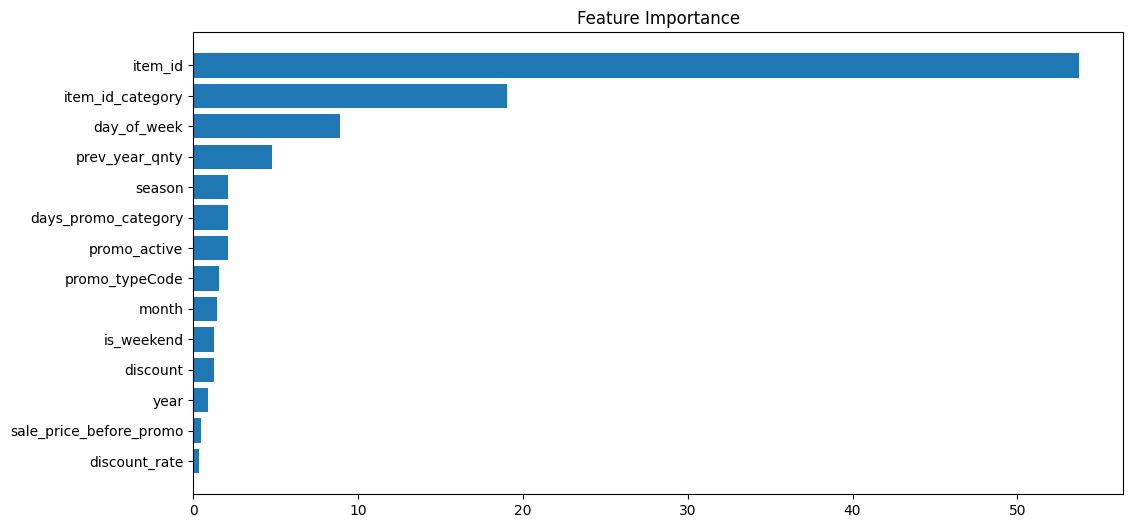

In [98]:
# основной вклад фичей
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')

In [100]:
x_pred = x_pred.drop(['date'], axis=1)
y_pred = model.predict(x_pred)
df_res['prediction'] = y_pred

In [106]:
# сохранение результата
df_res.to_csv('predictions.csv',sep=';', encoding='utf-8', index=False)